# Big Data Computing - HW2

In [1]:
import re
import numpy as np
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import Normalizer, scale
from sklearn.pipeline import make_pipeline
from collections import defaultdict, Counter, OrderedDict
from scipy.sparse import csc_matrix, diags
from wordcloud import WordCloud, ImageColorGenerator

## Loading data

The first thing we need to do is to load the data, which includes both the corpus and the labels.

In [2]:
corpus = []

with open('data/corpus.txt', 'r') as fp:
    for line in fp:
        corpus.append(line.rstrip('\n'))
        
corpus[:2]

["I purchased the Trilogy with hoping my two cats, age 3 and 5 would be interested.  The 3 yr old cat was fascinated for about 15 minutes but when the same pictures came on, she got bored.  The 5 year old watched for about a few minutes but then walked away. It is possible that because we have a wonderful courtyard full of greenery and trees and one of my neighbors has a bird feeder, that there is enough going on outside that they prefer real life versus a taped version.  I will more than likely pass this on to a friend who has cats that don't have as much wildlife to watch as mine do.",
 "Perfect for new parents. We were able to keep track of baby's feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!"]

In [2]:
labels = []

with open('data/labels.txt', 'r') as fp:
    for line in fp:
        labels.append(int(line))
        
labels[:5]

[1, 0, 1, 1, 0]

In [3]:
true_k = len(np.unique(labels))
true_k

2

## Pre-processing

In this section I am going to pre-process all the reviews present in the loaded corpus.  
The pre-processing of each review includes the following steps:
1. converting all the characters to **lower-case**
2. **removing** every character which isn't a letter of the alphabet or a number (which means **punctuation**, **special characters**, etc...) and **substituting multiple consecutive spaces with a single space**. This step is performed using regex.
3. **tokenizing** the review and applying **stemming** and **lemmatization** to each word (after some tests I found that lemmatization actually reduced both explained variance after SVD and accuracy of the clustering, so I decided to just apply stemming)
4. **joining back together** all the tokens

In [23]:
def process_string(s, stemmer, lemmatizer):
    proc_s = str(s).lower()
    proc_s = re.sub('[^a-z0-9 ]+', ' ', proc_s)
    tokens = word_tokenize(proc_s)
    for i, word in enumerate(tokens):
        if stemmer != None:
            word = stemmer.stem(word)
        if lemmatizer != None:
            word = lemmatizer.lemmatize(word)
        tokens[i] = word
    proc_s = " ".join(tokens)
    return proc_s

In [24]:
stemmer = SnowballStemmer("english")
# lemmatizer = WordNetLemmatizer()
processed_corpus = []

for s in tqdm(corpus):
    proc_s = process_string(s, stemmer, lemmatizer=None)
    processed_corpus.append(proc_s)

100%|████████████████████████████████████████████████████| 314808/314808 [03:15<00:00, 1610.60it/s]


In [25]:
# save processed corpus
with open("data/processed_corpus.txt", "w") as fp:
    for s in processed_corpus:
        fp.write(s + "\n")

In [4]:
# load processed corpus
processed_corpus = []
with open("data/processed_corpus.txt", "r") as fp:
    for line in fp:
        processed_corpus.append(line.rstrip('\n'))
processed_corpus[:2]

['i purchas the trilog with hope my two cat age 3 and 5 would be interest the 3 yr old cat was fascin for about 15 minut but when the same pictur came on she got bore the 5 year old watch for about a few minut but then walk away it is possibl that becaus we have a wonder courtyard full of greeneri and tree and one of my neighbor has a bird feeder that there is enough go on outsid that they prefer real life versus a tape version i will more than like pass this on to a friend who has cat that don t have as much wildlif to watch as mine do',
 'perfect for new parent we were abl to keep track of babi s feed sleep and diaper chang schedul for the first two and a half month of her life made life easier when the doctor would ask question about habit becaus we had it all right there']

Now I need to vectorize the corpus. First I will try **Tfidf vectorization** and later **Count vectorization**.

To each kind of vectorization I will apply **SVD** and, based on the explained variance obtained, I will decide which type of vectorization to use.

## Tfidf Vectorization

In [49]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_X = tfidf_vectorizer.fit_transform(processed_corpus)

In [50]:
tfidf_X.shape

(314808, 75140)

### SVD

In [51]:
def TSVD(X, n_components, normalize=False):
    tsvd = TruncatedSVD(n_components=n_components, random_state=0)
    if normalize:
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(tsvd, normalizer)
    else:
        lsa = tsvd
    Y = lsa.fit_transform(X)
    exp_var = tsvd.explained_variance_ratio_.sum()
    print("Explained variance:", round(exp_var, 5))
    return tsvd, Y

In [52]:
tsvd_tfidf, Y_tfidf = TSVD(tfidf_X, 2, True)

Explained variance: 0.01144


In [53]:
Y_tfidf.shape

(314808, 2)

## Count Vectorization and SVD

In [53]:
count_vectorizer = CountVectorizer(stop_words="english")  # max_df=10000, min_df=100
count_vec_X = count_vectorizer.fit_transform(processed_corpus)

In [54]:
count_vec_X.shape

(314808, 75140)

### SVD

In [55]:
tsvd_count, Y_count = TSVD(count_vec_X, 2, True)

Explained variance: 0.0751


In [56]:
Y_count.shape

(314808, 2)

As we can see, the SVD applied to the matrix obtained from the **CountVectorizer gives us an higher explained variance** compared to the Tfidf matrix. So, I will use the former one first to perform clustering, and then try the **TfidfVectorizer**.

After some tests on clustering, even though the CountVectorizer gives an higher explained variance, I noticed that the **Tfidf Vectorization** gives slightly better accuracuy on clustering. So, in the clustering section, I used Tfidf.

## Tfidf from scratch

As a last resource I decided to implement Tfidf from scratch to see how if the results would improve.  
After running the code, to my surprise, the SVD applied to the tfidf matrix computed from scratch gave a better explained variance compared to the Tfidf vectorizer previously tested and almost the same explained variance compared to the Count vectorizer.

The only problem lays in the fact that the amount of RAM requested to compute tfidf from scratch is far larger than the RAM requested for the sklearn methods. So, I decided to stick to the CountVectorized.

Below you can find the code for the implementation of TF-IDF from scratch. I don't suggest you to run it unless you have 16 or more GB of RAM available.

In [86]:
def get_words_df(corpus):
    words_df = defaultdict(int)
    stop_words = set(stopwords.words('english'))
    for text in corpus:
        words = set(text.split())
        for word in words:
            if word not in stop_words:
                words_df[word] += 1
    return words_df

In [87]:
words_df = get_words_df(processed_corpus)
len(words_df)

1280

In [88]:
def filter_words(words_df):
    double_chars = ['aa', 'bb', 'cc', 'dd', 'ee', 
      'ff', 'gg', 'hh', 'ii', 'll', 
      'mm', 'nn', 'oo', 'pp', 'qq', 
      'rr', 'ss', 'tt', 'uu', 'vv', 
      'zz', 'yy', 'ww']
    
    new_words_df = {}
    
    for word, cnt in words_df.items():
        if 1000 < cnt < 10000 and len(word) > 2:
            check = False
            for dc in double_chars:
                if word.startswith(dc) or word.endswith(dc):
                    check = True
                    break
            if check: continue
            if word.isalpha():
                new_words_df[word] = cnt
    return new_words_df

In [89]:
words_df = filter_words(words_df)
len(words_df)

1280

In [90]:
words_to_keep = set(list(words_df.keys()))
len(words_to_keep)

1280

In [91]:
def remove_words(corpus, words_to_keep):
    new_corpus = []
    for text in tqdm(corpus):
        new_text = []
        for word in text.split():
            if word in words_to_keep:
                new_text.append(word)
        new_corpus.append(" ".join(new_text))
    return new_corpus

In [92]:
processed_corpus = remove_words(processed_corpus, words_to_keep)

100%|██████████████████████████████████████████████████| 314808/314808 [00:01<00:00, 252312.83it/s]


In [93]:
processed_corpus[0]

'age interest pictur bore watch walk possibl wonder neighbor bird feeder outsid prefer real life tape version watch mine'

In [94]:
def get_vocab(corpus):
    vocab = {}
    term_id = 0
    for i, text in enumerate(corpus):
        for word in text.split():
            if word not in vocab:
                vocab[word] = term_id
                term_id += 1
    return vocab

In [95]:
vocab = get_vocab(processed_corpus)
len(vocab)

1280

In [96]:
def corpus_to_numeric(corpus, vocab):
    new_corpus = []
    for text in corpus:
        text_num = []
        for word in text.split():
            word_id = vocab[word]
            text_num.append(word_id)
        new_corpus.append(text_num)
    return new_corpus

In [97]:
corpus_numeric = corpus_to_numeric(processed_corpus, vocab)
corpus_numeric[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 4, 17]

In [98]:
def get_dense_matrix(corpus, num_words):
    text_counter = {}
    for _id, text in enumerate(corpus):
        c = OrderedDict(sorted(Counter(text).items()))
        text_counter[_id] = c
    
    matrix = np.zeros((len(text_counter), num_words))
    for _id, c in text_counter.items():
        matrix[_id, list(c.keys())] = list(c.values())

    return matrix

In [99]:
dense_matrix = get_dense_matrix(corpus_numeric, len(vocab))
dense_matrix.shape

(314808, 1280)

In [100]:
sparse_X = csc_matrix(dense_matrix)
sparse_X.shape

(314808, 1280)

In [101]:
del dense_matrix

In [102]:
inv_vocab = {j: i for i, j in vocab.items()}

In [103]:
def get_tfidf_matrix(sparse_X):
    # Get the number of reviews that use each word
    vector_non_zeros = np.array(sparse_X.getnnz(0))
    # Make it the idf vector
    vector_non_zeros_ = np.log(sparse_X.shape[0]/np.array(vector_non_zeros))
    # Create a diagonal matrix to speed up the operations
    diagonal_sparse = diags(1/vector_non_zeros_)
    # Get the tfidf sparse matrix
    tfidf = sparse_X @ diagonal_sparse
    return tfidf

In [104]:
tfidf_matrix = get_tfidf_matrix(sparse_X)
tfidf_matrix.shape

(314808, 1280)

### SVD

In [105]:
tsvd_scratch, Y_scratch = TSVD(tfidf_matrix, 2)

Explained variance: 0.33134


In [106]:
Y_scratch.shape

(314808, 50)

## Clustering

After computing SVD, it's now time to perform clustering on the data using the true_k given by the labels, which in this case corresponds to 2.

The clustering is performed using the **KMeans++** algorithm.

In [40]:
Y = Y_tfidf
km = KMeans(n_clusters=true_k, init='k-means++', 
            max_iter=1000, n_init=30,
            random_state=0, n_jobs=6, verbose=0)
km.fit(Y)

C:\Users\paolo\Anaconda3\envs\data_mining\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(max_iter=1000, n_clusters=2, n_init=30, n_jobs=6, random_state=0)

In [41]:
preds = km.predict(Y)
# preds = np.logical_not(preds).astype(int)

In [42]:
acc = metrics.accuracy_score(labels, preds)
print("Clustering accuracy with k=2")
print(acc)

Clustering accuracy with k=2
0.8411285609006124


In [43]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Y, km.labels_, sample_size=1000))

Homogeneity: 0.415
Completeness: 0.433
V-measure: 0.424
Adjusted Rand-Index: 0.465
Silhouette Coefficient: 0.648


Both the accuracy and the various metrics seem to be acceptable, so we can proceed by taking a look at the clusters.

In [44]:
print(km.cluster_centers_.shape)

(2, 2)


In [47]:
tsvd = tsvd_tfidf
original_centroids = tsvd.inverse_transform(km.cluster_centers_)
print(original_centroids.shape)
for i in range(original_centroids.shape[0]):
    original_centroids[i] = np.array([x for x in original_centroids[i]])
svd_centroids = original_centroids.argsort()[:, ::-1]

(2, 75140)


In [54]:
vectorizer = tfidf_vectorizer
terms = vectorizer.get_feature_names()

for i, comp in enumerate(tsvd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    s = ""
    for t in sorted_terms:
        s += t[0] + " "
    print(s)

Topic 0: 
dog use love like cat babi great veri toy just 
Topic 1: 
dog cat food treat toy eat chew love ball ingredi 


In [55]:
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in svd_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: use babi great veri love like just seat easi work
Cluster 1: dog cat love toy food like treat product good chew


### Visualization of the clusters using WordCloud

In [56]:
centroids_dict = {}
for i, centroid in enumerate(svd_centroids):
    l = [terms[term_id] for term_id in centroid]
    centroids_dict[i] = l

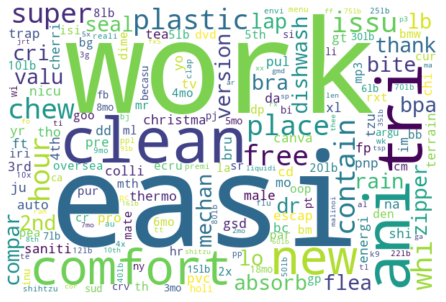

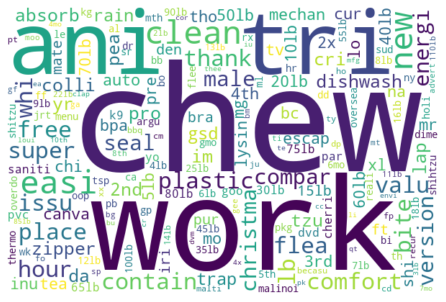

In [57]:
for i, centroid in centroids_dict.items():
    text = " ".join(centroid)
    wc = WordCloud(background_color='white',width = 600,height=400).generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()